In [1]:
import uproot
import awkward
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from graph import SparseGraph, make_sparse_graph, \
                  save_graph, save_graphs, load_graph, \
                  load_graphs, make_sparse_graph, graph_from_sparse

fname = '../../samples/partGun_PDGid13_x2_E35.0To35.0_NTUP_1.root'
#fname = './partGun_PDGid22_x1000_E2.0To100.0_NTUP_10.root'

test = uproot.open(fname)['ana']['hgc']

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

feature_names = ['x','y','layer','t','E']
n_features = len(feature_names)

#thanks Steve :-)
def draw_sample(X, Ri, Ro, y, 
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    # Select the i/o node features for each segment    
    feats_o = X[find(Ro)[0]]
    feats_i = X[find(Ri)[0]]    
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
    if sim_list is None:    
        # Draw the hits (layer, x, y)
        ax0.scatter(X[:,0], X[:,2], c='k')
        ax1.scatter(X[:,1], X[:,2], c='k')
    else:        
        ax0.scatter(X[sim_list,0], X[sim_list,2], c='b')
        ax1.scatter(X[sim_list,1], X[sim_list,2], c='b')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if not y[j] and skip_false_edges: continue
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,0], feats_i[j,0]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()

def draw_sample3d(X, Ri, Ro, y, 
                  cmap='bwr_r', 
                  skip_false_edges=True,
                  alpha_labels=False, 
                  sim_list=None):
    # Select the i/o node features for each segment
    feats_o = X[find(Ri)[0]]
    feats_i = X[find(Ro)[0]]
    # Prepare the figure
    fig = plt.figure()
    ax2 = fig.add_subplot(111, projection='3d')
    cmap = plt.get_cmap(cmap)
    
    if sim_list is None:    
        # Draw the hits (layer, x, y)
        ax2.scatter(X[:,0], X[:,1], X[:,2], c='k')
    else:        
        ax2.scatter(X[sim_list,0], X[sim_list,1], X[sim_list,2], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if not y[j] and skip_false_edges: continue
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))        
        ax2.plot([feats_o[j,0], feats_i[j,0]],
                 [feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,2], feats_i[j,2]],'-',**seg_args)
    # Adjust axes
    ax2.set_xlabel('$x$ [cm]')
    ax2.set_ylabel('$y$ [cm]')
    ax2.set_zlabel('$layer$ [arb]')

In [3]:
#example of generating a binary ground-truth adjacency matrix 
#for both endcaps in all events for all clusters
#truth is now that hits in adjacent layers are connected 
#and so are hits in the same layer within delta-R < 2 
arrays = test.arrays([b'simcluster_hits_indices',b'rechit_x',b'rechit_y',
                      b'rechit_z',b'rechit_layer',b'rechit_time',b'rechit_energy'])
rechit_x = arrays[b'rechit_x']
rechit_y = arrays[b'rechit_y']
rechit_z = arrays[b'rechit_z']

#flip the x's of negative-endcap hits
#so it's all uniform in x,y,layer coordinates
rechit_x.content[rechit_z.content < 0] *= -1

rechit_time = arrays[b'rechit_time']
rechit_energy = arrays[b'rechit_energy']
rechit_layer = arrays[b'rechit_layer']
sim_indices = awkward.fromiter(arrays[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


def get_features(ievt,mask):
    x = rechit_x[ievt][mask]
    y = rechit_y[ievt][mask]
    layer = rechit_layer[ievt][mask]
    time = rechit_time[ievt][mask]
    energy = rechit_energy[ievt][mask]    
    return np.stack((x,y,layer,time,energy)).T
    
def make_graph_kdtree(coords,layers,sim_indices,r=2.5):
    #setup kd tree for fast processing
    the_tree = cKDTree(coords)
    
    #define the pre-processing (all layer-adjacent hits in ball R < r)
    #and build a sparse matrix representation, then blow it up 
    #to the full R_in / R_out definiton
    pairs = the_tree.query_pairs(r=r,output_type='ndarray')
    first,second = pairs[:,0],pairs[:,1]  
    #selected index pair list that we label as connected
    pairs_sel  = pairs[( (np.abs(layers[(second,)]-layers[(first,)]) <= 1)  )]
    data_sel = np.ones(pairs_sel.shape[0])
    
    #prepare the input and output matrices (already need to store sparse)
    r_shape = (coords.shape[0],pairs.shape[0])
    eye_edges = np.arange(pairs_sel.shape[0])
    
    R_i = csr_matrix((data_sel,(pairs_sel[:,1],eye_edges)),r_shape,dtype=np.uint8)
    R_o = csr_matrix((data_sel,(pairs_sel[:,0],eye_edges)),r_shape,dtype=np.uint8)
        
    #now make truth graph y (i.e. both hits are sim-matched)    
    y = (np.isin(pairs_sel,sim_indices).astype(np.int8).sum(axis=-1) == 2)
    
    return R_i,R_o,y

for ievt in tqdm(range(rechit_z.size),desc='events processed'):
    
    pos_z_mask = (rechit_z[ievt] > 0)
    rh_pos_z, = np.where(pos_z_mask)
    rh_neg_z, = np.where(~pos_z_mask)
    rh_idx_map = np.zeros(pos_z_mask.size,dtype=np.int)
    rh_idx_map[pos_z_mask] = np.arange(rh_pos_z.size)
    rh_idx_map[~pos_z_mask] = np.arange(rh_neg_z.size)
        
    pos_feats = get_features(ievt,pos_z_mask)
    neg_feats = get_features(ievt,~pos_z_mask)
        
    pos_shape = (rh_pos_z.size,rh_pos_z.size)
    neg_shape = (rh_neg_z.size,rh_neg_z.size)
    
    all_sim_hits = np.unique(valid_sim_indices[ievt].flatten())
    pos_z_simmask = (rechit_z[ievt][all_sim_hits] > 0)
    pos_sim_hits = rh_idx_map[all_sim_hits[pos_z_simmask]]
    neg_sim_hits = rh_idx_map[all_sim_hits[~pos_z_simmask]]
    
    #make input graphs
    posRhLayers = rechit_layer[ievt][pos_z_mask]
    pos_Ri,pos_Ro,y_pos = make_graph_kdtree(np.stack((rechit_x[ievt][pos_z_mask],
                                                      rechit_y[ievt][pos_z_mask],
                                                      rechit_layer[ievt][pos_z_mask])).T,
                                      posRhLayers,
                                      pos_sim_hits,
                                      r=2.4)
    
    neg_z_mask = ~pos_z_mask
    negRhLayers = rechit_layer[ievt][neg_z_mask]
    neg_Ri,neg_Ro,y_neg = make_graph_kdtree(np.stack((rechit_x[ievt][neg_z_mask],
                                                      rechit_y[ievt][neg_z_mask],
                                                      rechit_layer[ievt][neg_z_mask])).T,
                                      negRhLayers,
                                      neg_sim_hits,
                                      r=2.4)
            
    #write the graph and truth graph out
    outbase = fname.split('/')[-1].replace('.root','')
    
    graph = make_sparse_graph(pos_feats,pos_Ri,pos_Ro,y_pos,pos_sim_hits)
    save_graph(graph, '%s_hgcal_graph_pos_evt%d.npz'%(outbase,ievt))
        
    graph = make_sparse_graph(neg_feats,neg_Ri,neg_Ro,y_neg,neg_sim_hits)
    save_graph(graph, '%s_hgcal_graph_neg_evt%d.npz'%(outbase,ievt))


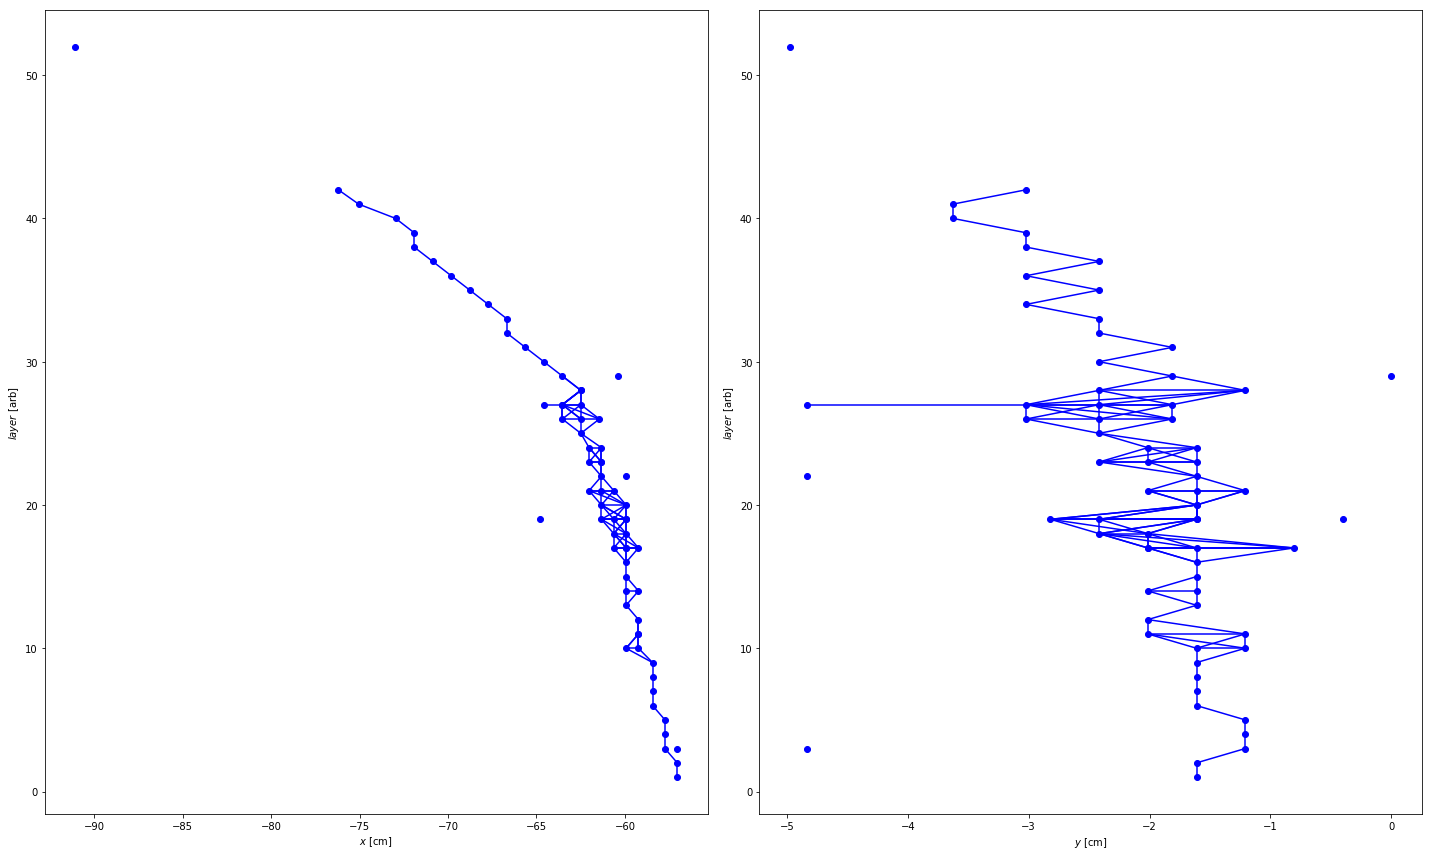

In [4]:
g1sparse = load_graph('partGun_PDGid13_x2_E35.0To35.0_NTUP_1_hgcal_graph_pos_evt0.npz')
g1 = graph_from_sparse(g1sparse)

#g1 = load_graph('partGun_PDGid13_x1000_Pt3.0To100.0_NTUP_1_hgcal_graph_neg_evt0.npz')

draw_sample(g1.X,g1.Ri,g1.Ro,g1.y,
            sim_list=g1.simmatched)

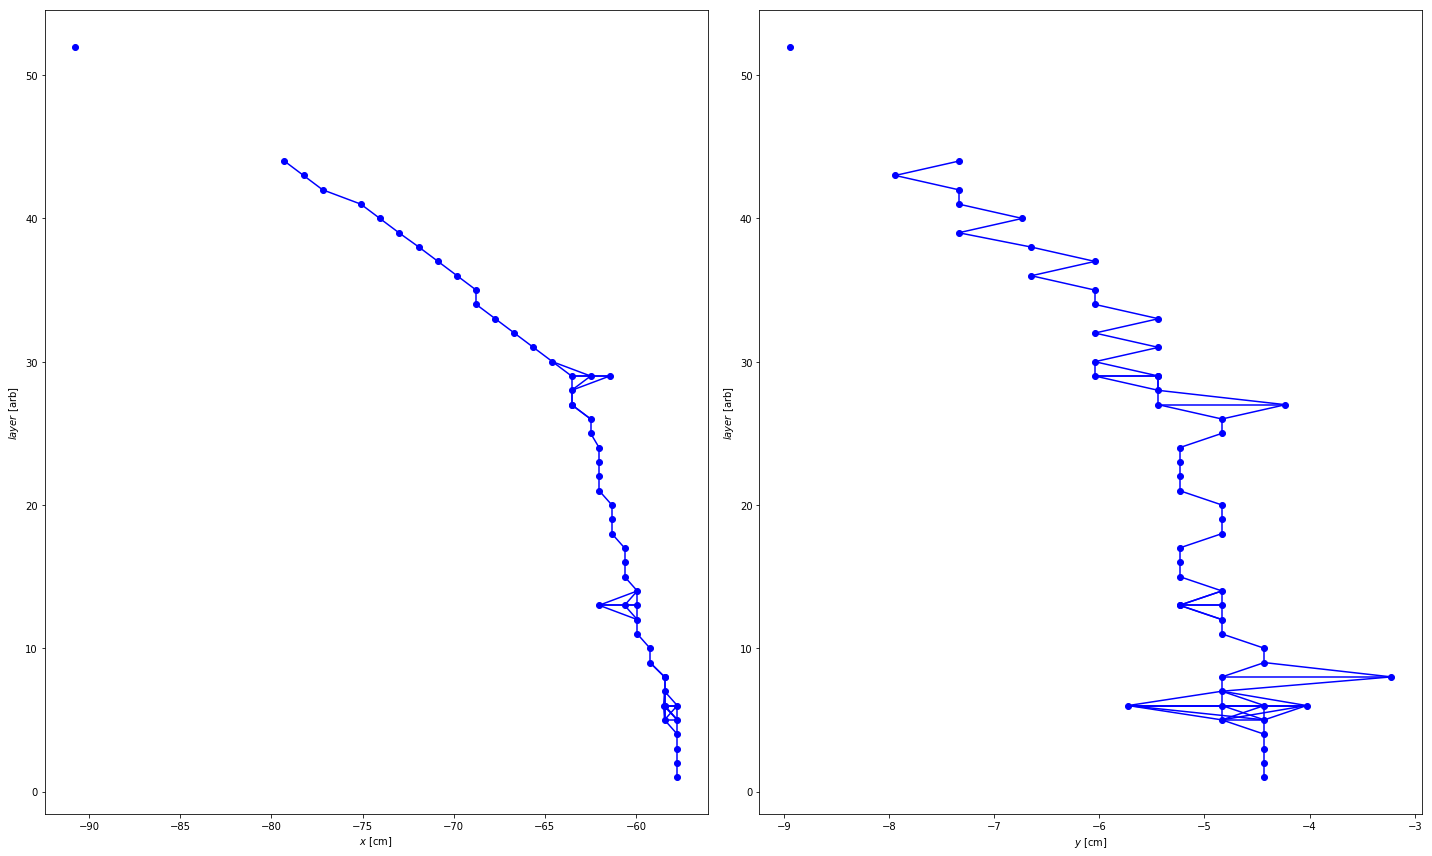

In [5]:
g2sparse = load_graph('partGun_PDGid13_x2_E35.0To35.0_NTUP_1_hgcal_graph_neg_evt0.npz')
g2 = graph_from_sparse(g2sparse)

draw_sample(g2.X,g2.Ri,g2.Ro,g2.y,
            sim_list=g2.simmatched)